In [2]:
#!pip install keplergl --quiet
import numpy as np
import pandas as pd
import geopandas as gpd
import keplergl
#from keplergl import KeplerGL
import matplotlib as plt
import plotly.express as px
#import h3
import shapely
from geopandas import GeoDataFrame,GeoSeries
import folium
import matplotlib
%matplotlib inline

In [49]:
#reading in data
#intersections = gpd.read_file('intersections_processed.geojson')
speed_enforcement = gpd.read_file('Automated Speed Enforcement Locations.geojson')

In [22]:
bikelanes = gpd.read_file('cycling-network.geojson')

In [5]:
road_network = gpd.read_file('road_network_processed.geojson')

In [6]:
road_network.columns

Index(['official_street_name', 'road_class', 'geometry'], dtype='object')

In [7]:
#convert column names to lowercase
road_network.columns = [s.strip().lower() for s in road_network.columns]
#filter only toronto roads
#road_network = road_network[road_network['r_standard_municipality'] == 'City of Toronto']

#dropping unneccessary columns

#specifying columns to keep
cols_to_keep = ['official_street_name','road_class','geometry']

#dropping columns
road_network = road_network[cols_to_keep]

In [15]:
import json
traffic_volumes = gpd.read_file('traffic volumes_2020_2029.csv')

In [16]:
#converting column headers to lowercase
traffic_volumes.columns = [s.strip().lower() for s in traffic_volumes.columns]

#dropping unneccesary columns
traffic_volumes = traffic_volumes.drop(columns=['_id','count_id','location_id','centreline_type','px'])

#dropping more unneccessary columns, as we have aggregate values of traffic counts
traffic_volumes.drop(traffic_volumes.columns[7:55],axis=1,inplace=True)

#getting geometry column for the traffic_volumes dataset
geometry = gpd.points_from_xy(x=traffic_volumes.lat,y=traffic_volumes.lng,crs=road_network.crs)

traffic_volumes = gpd.GeoDataFrame(traffic_volumes,geometry = geometry)

traffic_volumes_pivot = pd.pivot_table(traffic_volumes,values=['total_count','pedestrians_count','cyclists_count','vehicle_count','trucks_count'],index='centreline_id',aggfunc=sum)


In [17]:
traffic_volumes.head(2)

,count_date,location,lng,lat,centreline_id,time_start,time_end,total_count,pedestrians_count,cyclists_count,vehicle_count,trucks_count,geometry
0,08/01/2020,BROADVIEW AVE AT ERINDALE AVE,-79.35865235,43.67752083,13462138,2020-01-08T07:30:00,2020-01-08T07:45:00,274,63,4,207,1,POINT (43.67752 -79.35865)
1,08/01/2020,BROADVIEW AVE AT ERINDALE AVE,-79.35865235,43.67752083,13462138,2020-01-08T07:45:00,2020-01-08T08:00:00,244,54,3,187,0,POINT (43.67752 -79.35865)


In [35]:
bikelanes.columns = [s.strip().lower() for s in bikelanes.columns]
#drop unneeded columns
bikelanes = bikelanes.drop(columns=['objectid','segment_id','upgraded','pre_amalgamation','roadclass','cnpclass','surface','owner','dir_loworder','sepa_loworder','sepb_loworder','orig_loworder_infra','dir_highorder','sepa_highorder','sepb_highorder','orig_highorder','bylawed','editor','last_edit_date','upgrade_description','converted'])
#rename id column
bikelanes = bikelanes.rename(columns={'_id':'id'})

In [ ]:
bikelanes.head()

In [ ]:
road_network.head()

In [50]:
speed_enforcement.columns = [s.lower() for s in speed_enforcement.columns]
speed_enforcement = speed_enforcement.rename(columns={'_id':'id'})
speed_enforcement = speed_enforcement.drop(columns=['location_code','ward','status','fid'])

In [73]:
#intersections = intersections.to_crs('EPSG:3857')
#speed_enforcement = speed_enforcement.to_crs('EPSG:3857')
#bikelanes = bikelanes.to_crs('EPSG:3857')
road_network = road_network.to_crs('EPSG:3857')
traffic_volumes = traffic_volumes.to_crs('EPSG:3857')

In [105]:
#ensuring they both have same crs
traffic_volumes.crs = road_network.crs

In [97]:
#changing the geometry of traffic_volumes to multi point geometry
traffic_volumes.geometry = traffic_volumes.geometry.to_crs('EPSG:3857')

_____________________________________________

# Join with Road Network

In [78]:
#join = road_network.sjoin_nearest(bikelanes,how='inner',max_distance=100)

In [37]:
join = road_network.sjoin(bikelanes,how='inner')

In [38]:
road_network.shape

(50066, 3)

In [39]:
bikelanes.shape

(1323, 8)

In [40]:
join.shape

(4092, 11)

In [41]:
join.tail()

,official_street_name,road_class,geometry,index_right,id,installed,street_name,from_street,to_street,infra_loworder,infra_highorder
49671,LAWRENCE AVENUE EAST,Local / Street,"LINESTRING (-79.12198 43.78985, -79.12198 43.7...",1001,1002,2006,Waterfront Trl,Lawrence Ave E,Waterfront Trl Branch,Park Road,Park Road
49711,SYLVAN AVENUE,Collector,"LINESTRING (-79.43186 43.65498, -79.43035 43.6...",953,954,2014,Havelock St,Dewson St,Lindsey Ave,Signed Route (No Pavement Markings),Signed Route (No Pavement Markings)
49793,LAKEHURST DRIVE,Local / Street,"LINESTRING (-79.25748 43.69553, -79.25757 43.6...",784,785,2012,Lakehurst Dr,Kingston Rd,Lakehurst Cres,Signed Route (No Pavement Markings),Signed Route (No Pavement Markings)
49907,SECORD AVENUE,Local / Street,"LINESTRING (-79.30078 43.69301, -79.30008 43.6...",508,509,2005,Eastdale Rd,Lumsden Ave,Secord Ave,Signed Route (No Pavement Markings),Signed Route (No Pavement Markings)
50044,FREELAND STREET,Collector,"LINESTRING (-79.37297 43.64241, -79.37303 43.6...",1301,1302,2001,Martin Goodman Trl,Yonge St,100 m E of Cooper St,Multi-Use Trail - Boulevard,Multi-Use Trail - Boulevard


In [42]:
join.index_right.value_counts().sum()

4092

<AxesSubplot:>

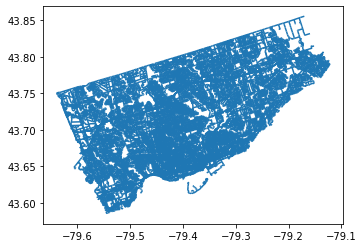

In [91]:
road_network.plot()

<AxesSubplot:>

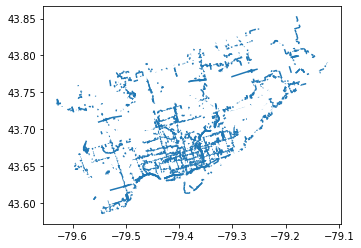

In [43]:
join.plot()

<AxesSubplot:>

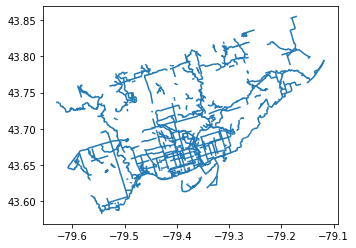

In [44]:
bikelanes.plot()

In [89]:
from keplergl import KeplerGl
KeplerGl(data={'data_1':join})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_1':         official_street_name      road_class  \
349     ST CLAIR AVENUE WEST        A…

In [88]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Join Traffic Volumes Data

In [45]:
join = join.drop(columns='index_right')

In [74]:
speed_enforcement.crs=join.crs

In [75]:
join_2 = join.sjoin_nearest(speed_enforcement,how='inner',max_distance=.5)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [76]:
join_2 = join_2.rename(columns={'index_right':'speed_enforcement'})

In [77]:
join_2.shape

(4143, 13)

In [78]:
join_2.head()

,official_street_name,road_class,geometry,id_left,installed,street_name,from_street,to_street,infra_loworder,infra_highorder,speed_enforcement,id_right,location
17,ST CLAIR AVENUE WEST,Arterial,"LINESTRING (-79.42572 43.68163, -79.42524 43.6...",1191,2007,Christie St,St Clair Ave W,Dupont St,Bike Lane,Bike Lane,43,44,Essex St. West of Christie St.
6643,CHRISTIE STREET,Arterial,"LINESTRING (-79.42426 43.67822, -79.42433 43.6...",1191,2007,Christie St,St Clair Ave W,Dupont St,Bike Lane,Bike Lane,43,44,Essex St. West of Christie St.
6675,CHRISTIE STREET,Arterial,"LINESTRING (-79.42308 43.67558, -79.42313 43.6...",1191,2007,Christie St,St Clair Ave W,Dupont St,Bike Lane,Bike Lane,43,44,Essex St. West of Christie St.
6939,CHRISTIE STREET,Arterial,"LINESTRING (-79.42274 43.67481, -79.42286 43.6...",1191,2007,Christie St,St Clair Ave W,Dupont St,Bike Lane,Bike Lane,43,44,Essex St. West of Christie St.
6998,CHRISTIE STREET,Arterial,"LINESTRING (-79.42258 43.67438, -79.42274 43.6...",1191,2007,Christie St,St Clair Ave W,Dupont St,Bike Lane,Bike Lane,43,44,Essex St. West of Christie St.


<AxesSubplot:>

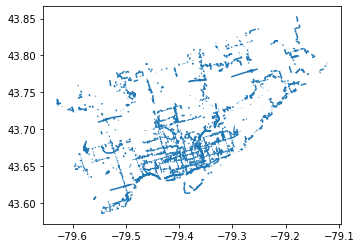

In [79]:
join_2.plot()

<AxesSubplot:>

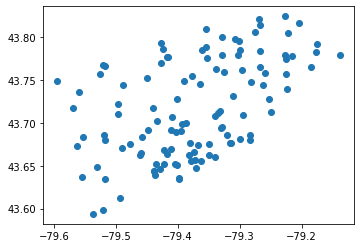

In [80]:
speed_enforcement.plot()

In [88]:
traffic_volumes.to_crs = join.crs

In [89]:
join_3 = join.sjoin_nearest(traffic_volumes,how='inner',max_distance=10)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [90]:
join_3.head()

,official_street_name,road_class,geometry,id,installed,street_name,from_street,to_street,infra_loworder,infra_highorder,...,lng,lat,centreline_id,time_start,time_end,total_count,pedestrians_count,cyclists_count,vehicle_count,trucks_count


________________________________________

# Join with Collisions

In [97]:
traffic_volumes.geometry

0         POINT (43.67752 -79.35865)
1         POINT (43.67752 -79.35865)
2         POINT (43.67752 -79.35865)
3         POINT (43.67752 -79.35865)
4         POINT (43.67752 -79.35865)
                     ...            
149194    POINT (43.72086 -79.44937)
149195    POINT (43.72086 -79.44937)
149196    POINT (43.72086 -79.44937)
149197    POINT (43.72086 -79.44937)
149198    POINT (43.72086 -79.44937)
Name: geometry, Length: 149199, dtype: geometry